# Tensorflow Lite Hands-on


For this notebook, there is a [current error](https://github.com/tensorflow/tensorflow/issues/84104) with the `tensorflow_datasets`, which has been fixed but not been integrated into their latest pip installable version yet. This error affects Windows machine. 


For Linux/MacOS, after activate the tf conda environment, you can install the following:

~~~bash
pip install tensorflow_hub tensorflow_datasets
~~~

For Windows, you will have to create a new conda environment and downgrade your tensorflow package to use an older model of tensorflow_datasets:

~~~bash
conda create -n tf2.10 python=3.10
conda activate tf2.10
pip install tensorflow==2.10 tensorflow_hub==0.12.0 tensorflow_datasets==4.6.0
pip install ipykernel
pip install opencv-python scipy pooch matplotlib jupyter numpy<2
~~~

You will need to use the new `tf2.10` environment for this notebook. 

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pylab as plt

import os
import zipfile
import requests

In [3]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

def format_image(image, label):
    image = tf.image.resize(image, (224, 224)) / 255.0
    return  image, label

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [4]:
num_examples = metadata.splits['train'].num_examples
num_classes = metadata.features['label'].num_classes
print(num_examples)
print(num_classes)

BATCH_SIZE = 32
train_batches = raw_train.shuffle(num_examples // 4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = raw_validation.map(format_image).batch(BATCH_SIZE).prefetch(1)
test_batches = raw_test.map(format_image).batch(1)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

23262
2


2025-02-26 14:42:44.186674: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-02-26 14:42:45.444661: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


TensorShape([32, 224, 224, 3])

In [ ]:
# Tested on MacOS

module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/4".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
print("Using {} with input size {} and output dimension {}".format(MODULE_HANDLE, IMAGE_SIZE, FV_SIZE))

feature_extractor = hub.KerasLayer(MODULE_HANDLE,
                                   input_shape=IMAGE_SIZE + (3,),
                                   output_shape=[FV_SIZE],
                                   trainable=False)

print("Building model with", MODULE_HANDLE)

class CustomHubLayer(tf.keras.layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.hub_layer = hub_layer

    def call(self, inputs):
        return self.hub_layer(inputs)
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_layer.handle  # Save the URL of the Hub model
        })
        return config

    @classmethod
    def from_config(cls, config):
        hub_layer = hub.KerasLayer(config["hub_url"], trainable=False)
        return cls(hub_layer)

# Wrap feature extractor
feature_extractor = CustomHubLayer(feature_extractor)

# This works for tensorflow 2.10
model = tf.keras.Sequential([
        feature_extractor,
        tf.keras.layers.Dense(num_classes, activation='softmax')
])


model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

EPOCHS = 5

hist = model.fit(train_batches,
                 epochs=EPOCHS,
                 validation_data=validation_batches)

Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280
Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ custom_hub_layer                │ ?                      │   0 (unbuilt) │
│ (CustomHubLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 82s 137ms/step - accuracy: 0.9537 - loss: 0.1069 - val_accuracy: 0.9815 - val_loss: 0.0473
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 133ms/step - accuracy: 0.9895 - loss: 0.0302 - val_accuracy: 0.9867 - val_loss: 0.0382
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 81s 137ms/step - accuracy: 0.9924 - loss: 0.0253 - val_accuracy: 0.9841 - val_loss: 0.0411
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - accuracy: 0.9938 - loss: 0.0208 - val_accuracy: 0.9862 - val_loss: 0.0418
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - accuracy: 0.9924 - loss: 0.0200 - val_accuracy: 0.9862 - val_loss: 0.0429


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

# Define model parameters
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = f"https://tfhub.dev/google/tf2-preview/{handle_base}/feature_vector/4"
IMAGE_SIZE = (pixels, pixels)

print(f"Using {MODULE_HANDLE} with input size {IMAGE_SIZE} and output dimension {FV_SIZE}")

# Define input layer
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,), dtype=tf.float32)

# Initialize hub.KerasLayer correctly
feature_extractor_layer = hub.KerasLayer(MODULE_HANDLE, trainable=False)
x = tf.keras.layers.Lambda(lambda img: feature_extractor_layer(img))(inputs)  # Ensure inputs are passed correctly

# Ensure output is correctly formatted
x = tf.keras.layers.Dense(10, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs, x)

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
model.summary()

# Train the model
EPOCHS = 5

hist = model.fit(
    train_batches,  # Ensure train_batches is correctly loaded
    epochs=EPOCHS,
    validation_data=validation_batches
)


Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_1 (Lambda)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 134ms/step - accuracy: 0.9462 - loss: 0.1532 - val_accuracy: 0.9862 - val_loss: 0.0392
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 137ms/step - accuracy: 0.9894 - loss: 0.0306 - val_accuracy: 0.9880 - val_loss: 0.0388
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 136ms/step - accuracy: 0.9911 - loss: 0.0259 - val_accuracy: 0.9888 - val_loss: 0.0405
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 136ms/step - accuracy: 0.9921 - loss: 0.0235 - val_accuracy: 0.9893 - val_loss: 0.0399
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 134ms/step - accuracy: 0.9932 - loss: 0.0209 - val_accuracy: 0.9854 - val_loss: 0.0415


## Important Debugging Issue

Tensorflow's is being upgraded quickly, and many codes that work previously no longer work now. The section belows is the debugging that 
was done to ensure the model can be properly saved. 

In [12]:
assert isinstance(model, tf.keras.Model), "The model is not a valid Keras Model!"
for layer in model.layers:
    if isinstance(layer, tf.Module):
        print(f"Layer {layer.name} is a valid tf.Module")
    else:
        print(f"Layer {layer.name} may have issues")

Layer input_layer_5 may have issues
Layer lambda_1 may have issues
Layer dense_1 may have issues


In [10]:
#CATS_VS_DOGS_SAVED_MODEL = "my_model_savedmodel"
#model.save("my_model.keras")
#model = tf.keras.models.load_model("my_model.keras")
#tf.saved_model.save(model, CATS_VS_DOGS_SAVED_MODEL)

# Use export if tensorflow 2.18
#tf.saved_model.export(model, CATS_VS_DOGS_SAVED_MODEL)


In [11]:
import tensorflow as tf
import tensorflow_hub as hub

# Define module parameters
module_selection = ("mobilenet_v2", 224, 1280)
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE = f"https://tfhub.dev/google/tf2-preview/{handle_base}/feature_vector/4"
IMAGE_SIZE = (pixels, pixels)

print(f"Using {MODULE_HANDLE} with input size {IMAGE_SIZE} and output dimension {FV_SIZE}")

# Define a custom Keras layer to wrap `hub.KerasLayer`
class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super().__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(hub_url, trainable=False)

    def call(self, inputs):
        return self.hub_layer(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({"hub_url": self.hub_url})
        return config

    @classmethod
    def from_config(cls, config):
        return cls(hub_url=config["hub_url"])

# Define the input layer
inputs = tf.keras.Input(shape=IMAGE_SIZE + (3,), dtype=tf.float32)

# Use the custom wrapper for hub.KerasLayer
feature_extractor_layer = HubLayerWrapper(MODULE_HANDLE)(inputs)

# Add classification layer
outputs = tf.keras.layers.Dense(10, activation='softmax')(feature_extractor_layer)

# Create the model
model = tf.keras.Model(inputs, outputs)

# Print model summary
model.summary()

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
EPOCHS = 5

hist = model.fit(
    train_batches,  # Ensure train_batches is correctly loaded
    epochs=EPOCHS,
    validation_data=validation_batches
)


Using https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4 with input size (224, 224) and output dimension 1280


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hub_layer_wrapper               │ (None, 1280)           │             0 │
│ (HubLayerWrapper)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 77s 129ms/step - accuracy: 0.9482 - loss: 0.1602 - val_accuracy: 0.9828 - val_loss: 0.0404
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 80s 136ms/step - accuracy: 0.9894 - loss: 0.0341 - val_accuracy: 0.9858 - val_loss: 0.0402
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 76s 129ms/step - accuracy: 0.9891 - loss: 0.0299 - val_accuracy: 0.9841 - val_loss: 0.0454
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 78s 133ms/step - accuracy: 0.9908 - loss: 0.0260 - val_accuracy: 0.9901 - val_loss: 0.0391
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 135ms/step - accuracy: 0.9922 - loss: 0.0221 - val_accuracy: 0.9875 - val_loss: 0.0399


In [ ]:
import pathlib
#converter = tf.lite.TFLiteConverter.from_saved_model(CATS_VS_DOGS_SAVED_MODEL)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("./")

tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes

In [7]:
from tqdm import tqdm
# Load TFLite model and allocate tensors.
tflite_model_file = './model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

predictions = []

# This will report how many iterations per second, where each
# iteration is 100 predictions
test_labels, test_imgs = [], []
for img, label in tqdm(test_batches.take(100)):
    interpreter.set_tensor(input_index, img)
    interpreter.invoke()
    predictions.append(interpreter.get_tensor(output_index))

    test_labels.append(label.numpy()[0])
    test_imgs.append(img)


# This will tell you how many of the predictions were correct
score = 0
for item in range(0,len(predictions)):
  prediction=np.argmax(predictions[item])
  label = test_labels[item]
  if prediction==label:
    score=score+1

print("Out of 100 predictions I got " + str(score) + " correct")



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
100%|██████████| 100/100 [00:00<00:00, 117.91it/s]

Out of 100 predictions I got 100 correct


In [8]:

#@title Utility functions for plotting
# Utilities for plotting

class_names = ['cat', 'dog']

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    img = np.squeeze(img)

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)

    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]), color=color)

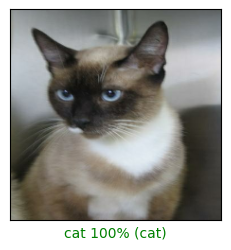

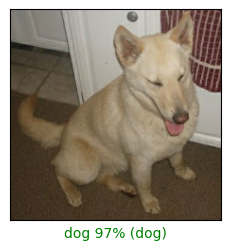

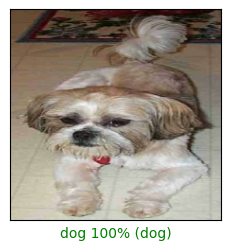

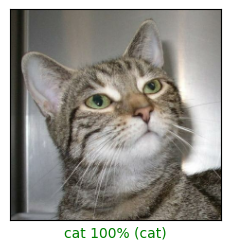

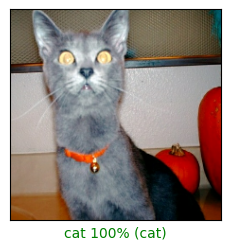

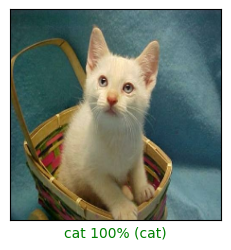

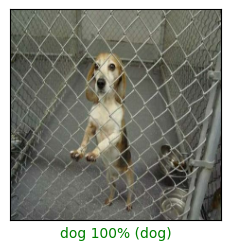

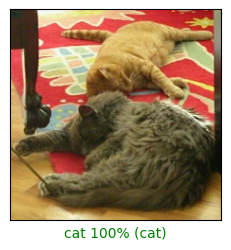

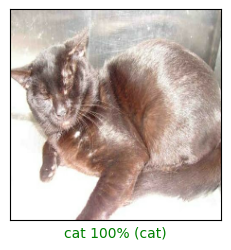

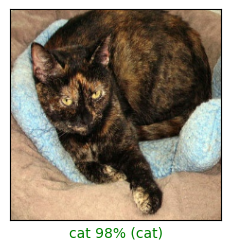

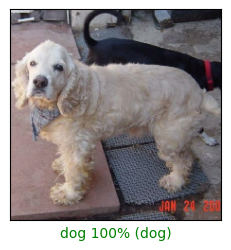

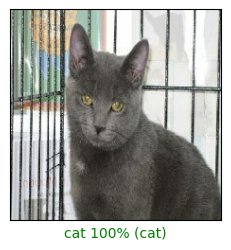

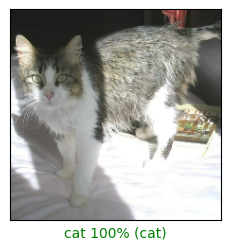

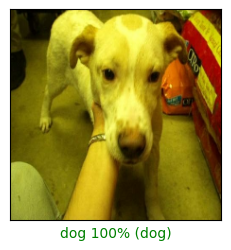

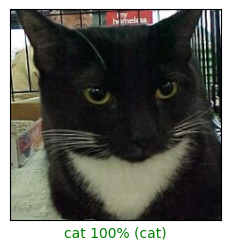

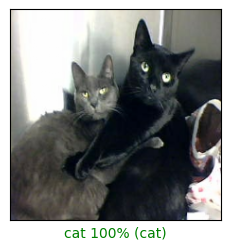

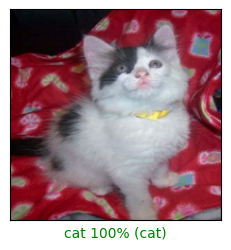

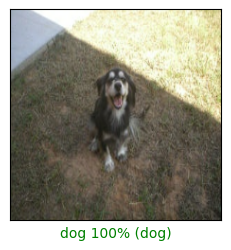

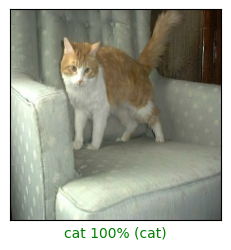

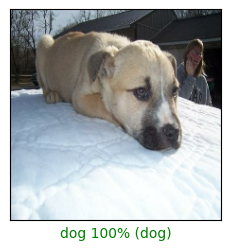

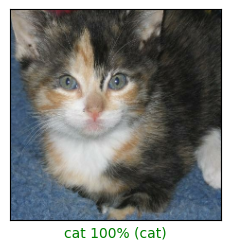

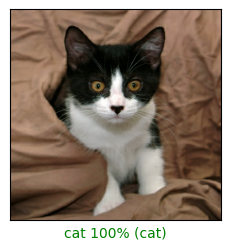

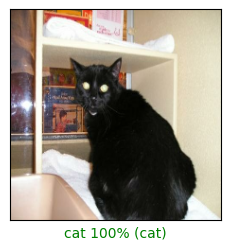

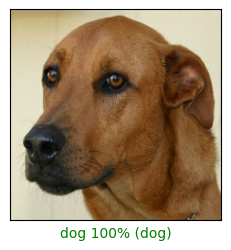

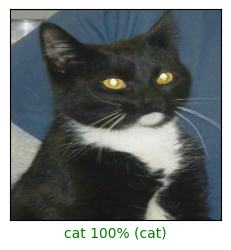

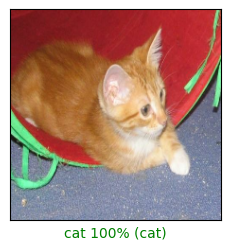

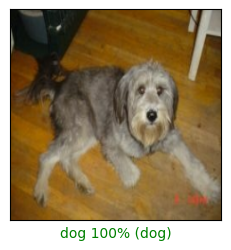

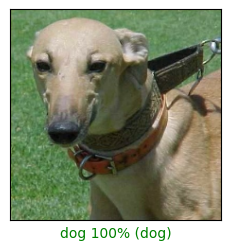

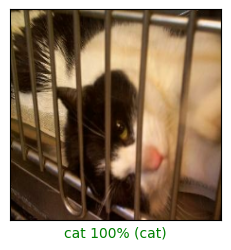

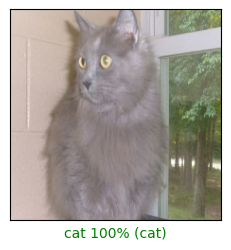

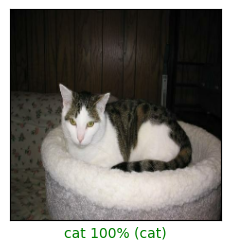

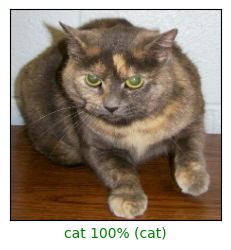

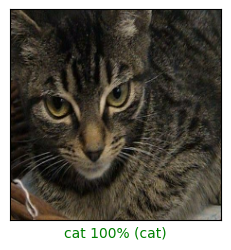

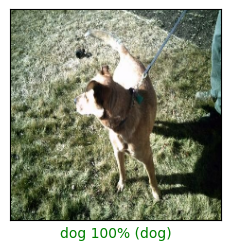

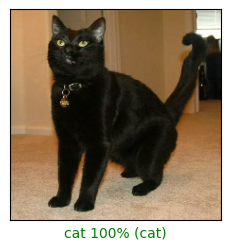

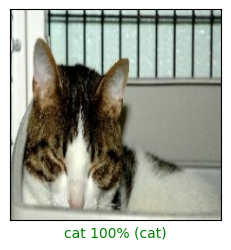

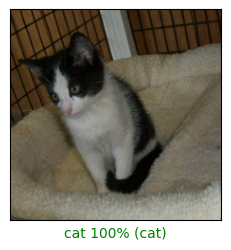

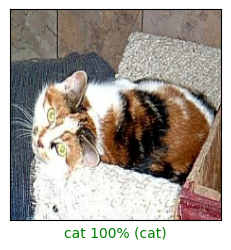

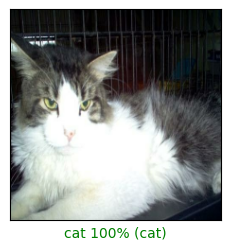

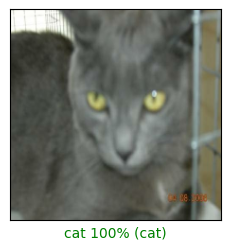

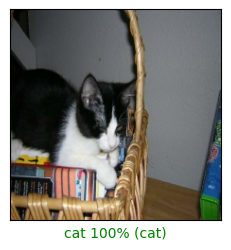

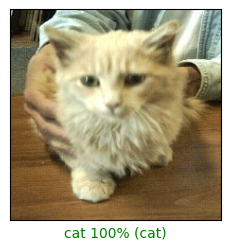

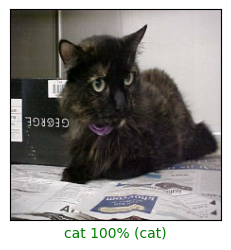

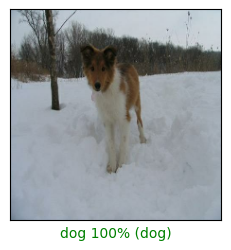

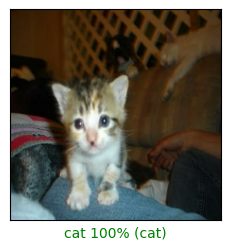

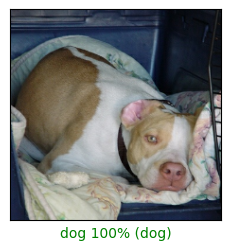

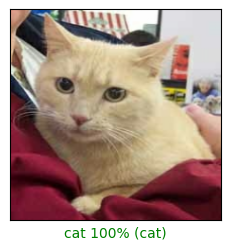

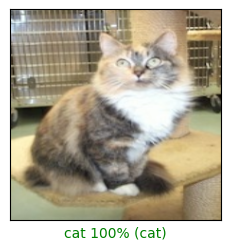

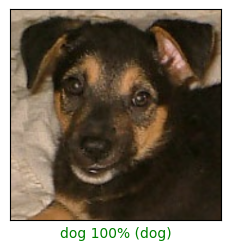

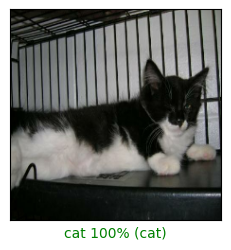

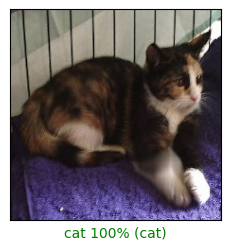

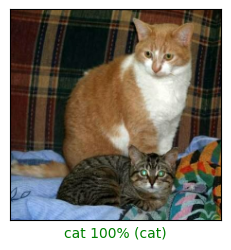

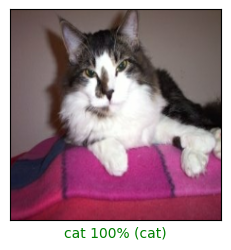

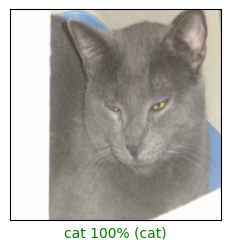

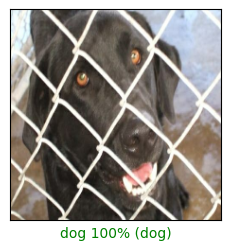

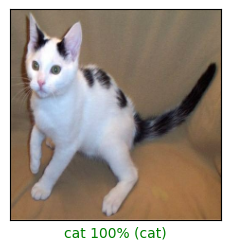

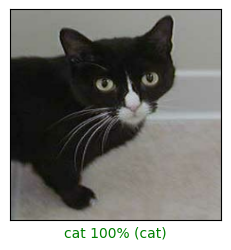

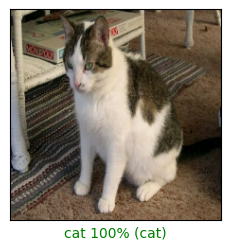

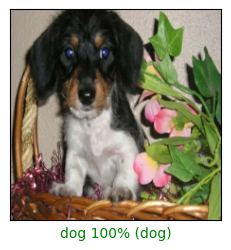

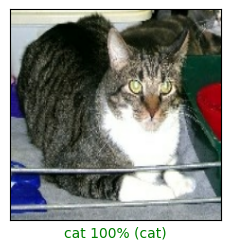

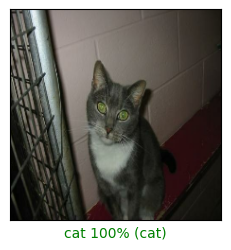

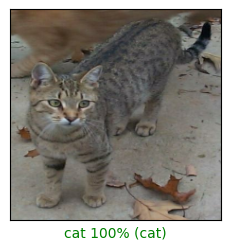

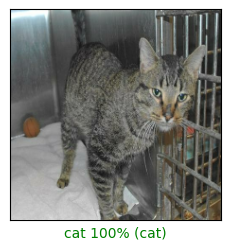

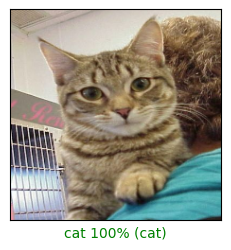

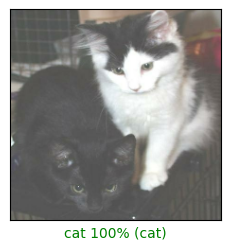

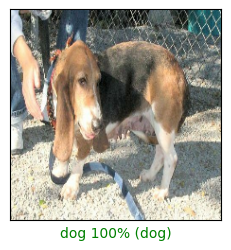

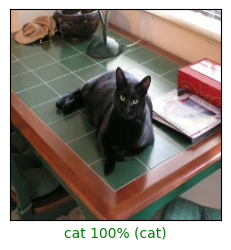

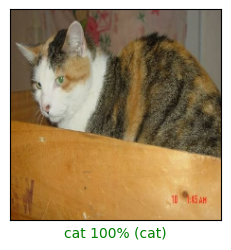

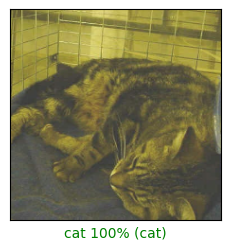

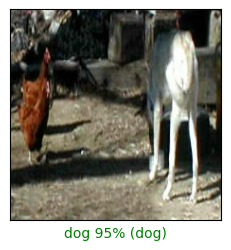

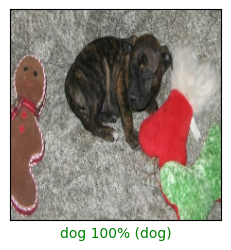

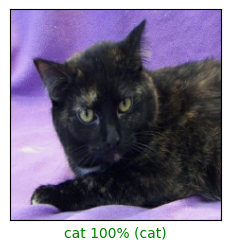

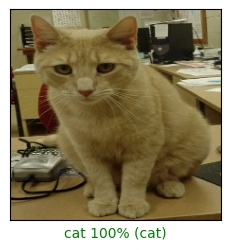

In [9]:

#@title Visualize the outputs { run: "auto" }
max_index = 73 #@param {type:"slider", min:1, max:100, step:1}
for index in range(0,max_index):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  plot_image(index, predictions, test_labels, test_imgs)
  plt.show()

## Further Study

To learn more about post-training quantization and optimization, please check out the user guides at https://www.tensorflow.org/lite/performance/post_training_quantization